In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
import cyipopt as ipopt
import cvxpy as cp

In [2]:
class erc(object):
    # Define objective function, constraints, gradient of objective fucntion, and jacobian of constrants for the ERC problem.
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            n = 20
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            n = 20
            grad = np.zeros(n)
            # Insert your gradient computations here
            # You can use finite differences to check the gradient
            y = x * np.dot(Q,x)
            for i in range(n):
                for j in range(i,n):
                    diff1 = Q[i].dot(x) + Q[i,i] * x[i]
                    diff2 = Q[i,j] * x[i]
                    g = (y[i]-y[j]) * (diff1 - diff2)
                    grad[i] = grad[i] + g
                grad[i] = 4 *  grad[i]
            return grad


        def constraints(self, x):
            # The callback for calculating the constraints
            n = 20
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            n = 20
            return np.array([[1.0] * n])



In [3]:
# Complete the following functions

def cash_check(target_units, x_init, target_weight, cash_init, cur_prices, current_borrow, interest):
    
    #calculate cash short fall: (the cash difference between selling and buying all the stocks + commission cost) - initial cash
    #if the number is positive, there's a shortfall. otherwise cash is enough to execute the rebalance
    cash_shortfall = ((np.dot((target_units - x_init), cur_prices) + 
                      (np.dot(np.abs(target_units - x_init), cur_prices)*0.005) + interest) - 
                      cash_init - current_borrow)
    if cash_shortfall > 0:
        #see what's the percentage of the cash shortfall to the current portfolio
        shortfall_pct = cash_shortfall/((np.dot(x_init, cur_prices)+ cash_init) + current_borrow)
        #update the target units with leaving out the needed cash from the portfolio  
        updated_target_units = (np.round(target_weight * 
                                         ((np.dot(x_init, cur_prices)+ cash_init) + 
                                          current_borrow-cash_shortfall)))/cur_prices
        
#         updated_target_units = (np.floor(target_weight * 
#                                          ((np.dot(x_init, cur_prices)+ cash_init)*(1-shortfall_pct))))/cur_prices
        #chekcing the cash shortfall again
        if ((np.dot((updated_target_units - x_init), cur_prices) + 
                      (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005) + interest) - 
                      cash_init - current_borrow) > 0:
            print("Not enough cash to rebalance for Equal Weighted strat. Please check the rebalance function")

    else:
        updated_target_units = target_units
    
    return updated_target_units

def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    #no leverage
    borrowed_amount = 0
    current_borrow = 0
    interest = 0
    
    x_optimal = x_init
    cash_optimal = cash_init
    weight_optimal = (x_init*cur_prices)/(np.dot(x_init, cur_prices)+ cash_init)
    trading_cost = 0

    return x_optimal, cash_optimal, weight_optimal, borrowed_amount, trading_cost

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    #no leverage
    borrowed_amount = 0
    current_borrow = 0
    interest = 0
    # equally divide portfolio to derive the value for each security
    equal_value = (np.dot(x_init, cur_prices)+ cash_init)/len(x_init)
    # get target weight
    target_weight = np.full((1, len(x_init)), 1/len(x_init))[0]
    # use np.round to make sure the share units are rounded down to integer
    target_units = np.ceil(equal_value/cur_prices) 
    #check if we can cover the rebalance and update weight if needed
    updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices, current_borrow, interest)
    
    
    x_optimal = updated_target_units
    cash_optimal = (cash_init + 
                    (-np.dot((updated_target_units - x_init), cur_prices)) -
                    (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005))
    weight_optimal = target_weight
    trading_cost = np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005
    
    return x_optimal, cash_optimal, weight_optimal, borrowed_amount, trading_cost



def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    #no leverage
    borrowed_amount = 0
    current_borrow = 0
    interest = 0
    
    n = len(x_init)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    # setup coefficients of the objective function, bounds on the variables 
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    # set variable constraint matrix
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    A
    
    var_names = ["w_%s" % i for i in range(1,n+1)]

    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    
    cpx.objective.set_quadratic(Qmat)
    
    cpx.solve()
    
    target_weight = np.array(cpx.solution.get_values())
#     print(target_weight)
    target_units = np.ceil(((np.dot(x_init, cur_prices)+ cash_init) * target_weight)/cur_prices)
#     print(target_units)
    
    updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices, current_borrow, interest)
    
    x_optimal = updated_target_units
    cash_optimal = (cash_init + 
                    (-np.dot((updated_target_units - x_init), cur_prices)) -
                    (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005))
    
    
    weight_optimal = target_weight
    trading_cost = np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005
    
    return x_optimal, cash_optimal, weight_optimal, borrowed_amount, trading_cost



def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    #no leverage
    borrowed_amount = 0
    current_borrow = 0
    interest = 0
    
    n = len(x_init)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    #Value of kappa may be greater than 1, thus np.inf is used as bound
    c  = [0.0] * (n+1)
    lb = [0.0] * (n+1)
    ub = [np.inf] * (n+1)                                   

    #risk-free rate
    if cur_year == 2008 or 2009:
        r_rf = 0.045
    elif cur_year == 2022:
        r_rf = 0.0375
    else:
        r_rf = 0.025
    #daily risk-free rate
    daily_r_rf = (r_rf+1)**(1.0/252)-1 #daily risk-free rate
    alpha = mu - daily_r_rf
    #Add a column and a row of 0 to allow the optimization of kappa
    c_k = np.zeros((n,1))        
    Q1 = np.hstack((Q,c_k))
    c_k = np.zeros((1,n+1))        
    Q2 = np.vstack((Q1,c_k))
    #Append -1 so that the constraint becomes [sum(wi)- kappa = 0]
    A = []
    for k in range(n):
        A.append([[0,1],[alpha[k],1]])
    A.append([[0,1],[0,-1]])                           


    var_names = ["w_%s" % i for i in range(1,n+1+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n+1)), list(2*Q2[k,:])] for k in range(n+1)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string() == 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
        weight_optimal = (x_init*cur_prices)/ (np.dot(x_init, cur_prices)+ cash_init)
        trading_cost = 0
    else:
    
    
        y_opt = np.array(cpx.solution.get_values())                         
        target_weight = y_opt[0:20]/y_opt[20]   

        target_units = np.ceil(((np.dot(x_init, cur_prices)+ cash_init) * target_weight)/cur_prices)

        updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices, current_borrow, interest)

        x_optimal = updated_target_units
        cash_optimal = (cash_init + 
                        (-np.dot((updated_target_units - x_init), cur_prices)) -
                        (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005))
        weight_optimal = target_weight
        trading_cost = np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005
    
    return x_optimal, cash_optimal, weight_optimal, borrowed_amount, trading_cost



def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    #no leverage
    borrowed_amount = 0
    current_borrow = 0
    interest = 0
    
    n = len(x_init)
    w0 = [1.0/n] * n
     
    # Define objective function, constraints, gradient of objective fucntion, and jacobian of constrants for the ERC problem.
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    # Compute variance and asset risk contributions for the ERC portfolio
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    
    target_weight = w_erc  
    target_units = np.ceil(((np.dot(x_init, cur_prices)+ cash_init) * target_weight)/cur_prices)
    
    updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices, current_borrow, interest)
    
    x_optimal = updated_target_units
    cash_optimal = (cash_init + 
                    (-np.dot((updated_target_units - x_init), cur_prices)) -
                    (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005))
    weight_optimal = target_weight
    trading_cost = np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005


    return x_optimal, cash_optimal, weight_optimal, borrowed_amount, trading_cost

def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = len(x_init)
    w0 = [1.0/n] * n
    #risk-free rate
    if cur_year == 2008 or 2009:
        r_rf = 0.045
    elif cur_year == 2022:
        r_rf = 0.0375
    else:
        r_rf = 0.025
    #set borrow amount and interest    
    borrowed_amount = init_value
    interest = borrowed_amount*(r_rf/6)
    
    #calculation of portfolio value
    if period == 1:
        current_borrow = borrowed_amount
    else:
        current_borrow = 0

    #set port value   
    portfolio_V = np.dot(cur_prices, x_init) + cash_init + current_borrow
    
    
    lb = [0] * n
    ub = [1] * n
    cl = [1]
    cu = [1]
    #define the IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    #set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    #solve the problem
    w_lerc, info = nlp.solve(w0)
    w_lerc = np.array(w_lerc)
    w_lerc = w_lerc*(1/w_lerc.sum())
    each_asset_V = w_lerc * portfolio_V
    
    target_weight = w_lerc
    #get units and include leverage 
    target_units = np.ceil((portfolio_V  * target_weight)/cur_prices)
    
    updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices, current_borrow, interest)

        
    x_optimal = updated_target_units
    cash_optimal = (cash_init + 
                    current_borrow +
                    (-np.dot((updated_target_units - x_init), cur_prices)) -
                    (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005) - 
                    interest)
    weight_optimal = target_weight
    trading_cost = np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005

    return x_optimal, cash_optimal, weight_optimal, borrowed_amount, trading_cost

def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    #no leverage
    borrowed_amount = 0
    current_borrow = 0
    interest = 0

    n = len(x_init)
    w0 = [1.0/n] * n
    
    portfolio_V = np.dot(cur_prices, x_init) + cash_init
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    #############
        
    #required robustness
    var_matr = np.diag(np.diag(Q))
    # Target portfolio return estimation error is return estimation error of 1/n portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
    rob_bnd  = rob_init
    

    #Define linear part of objective function and bounds on variables, no linear part
    c = [0.0]*n 
    lb = [0.0]*n
    cols = []
    for i in range(n):
        cols.append([[0],[1]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    #add linear obj, constr, lb to model
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    cpx.variables.add(obj=c, lb=lb, columns=cols, names = var_names)

    #define part of obj 
    qmat =[[list(range(n)),list(2*Q[i,:])] for i in range(n)]
    cpx.objective.set_quadratic(qmat)
    
    #set paramters
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()
    w1 = np.array(cpx.solution.get_values())
    w_minVar = w1
    var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
    ret_minVar = np.dot(mu, w_minVar)
    # Target portfolio return is return of minimum variance portfolio
    Portf_Retn = ret_minVar

    ##############
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n 
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
   

    w_rMV = cpx.solution.get_values()
    # Round near-zero portfolio weights
    w_rMV = np.array(w_rMV)

    target_weight = w_rMV

    target_units = np.ceil((portfolio_V  * target_weight)/cur_prices)

    updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices, current_borrow, interest)

    x_optimal = updated_target_units
    cash_optimal = (cash_init + 
                    current_borrow +
                    (-np.dot((updated_target_units - x_init), cur_prices)) -
                    (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005) - 
                    interest)
    weight_optimal = target_weight
    trading_cost = np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005
    
    return x_optimal, cash_optimal, weight_optimal, borrowed_amount, trading_cost
  

In [4]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

In [5]:
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [6]:
# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [7]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

In [8]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000013.0



In [9]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [10]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

In [11]:
# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

In [12]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 7  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

In [13]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
borrowed_amount = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
trading_cost = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
start_list = np.zeros(N_periods)
end_list = np.zeros(N_periods)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   start_list[period-1] = day_ind_start 
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   end_list[period-1] = day_ind_end
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      (x[strategy, period-1], 
        cash[strategy, period-1], 
        weight[strategy, period-1], 
        borrowed_amount[strategy, period-1], 
        trading_cost[strategy, period-1]) = fh_array[strategy](curr_positions, 
                                                                 curr_cash, 
                                                                 mu, 
                                                                 Q, 
                                                                 cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # Compute portfolio value & deduct the borrowed amount
      p_values = (np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + 
                  cash[strategy, period-1] - 
                  borrowed_amount[strategy, period-1])
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################



Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000013.00, value end = $ 893956.82
  Strategy "Equally Weighted Portfolio", value begin = $ 990889.43, value end = $ 893216.06
  Strategy "Mininum Variance Portfolio", value begin = $ 992757.96, value end = $ 916383.64
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990084.29, value end = $ 922483.31
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991305.08, value end = $ 899760.03
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 979782.35, value end = $ 796912.57
  Strategy "Robust Optimization Portfolio", value begin = $ 992161.88, value end = $ 917679.41

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931416.57, value end = $ 862900.41
  Strategy "Mininum Variance Portfolio", value begin = $ 9

  Strategy "Mininum Variance Portfolio", value begin = $ 1055037.28, value end = $ 1049227.96
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2119092.77, value end = $ 2224903.48
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1468877.80, value end = $ 1521989.38
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1828581.24, value end = $ 1931098.64
  Strategy "Robust Optimization Portfolio", value begin = $ 1230919.55, value end = $ 1258285.18


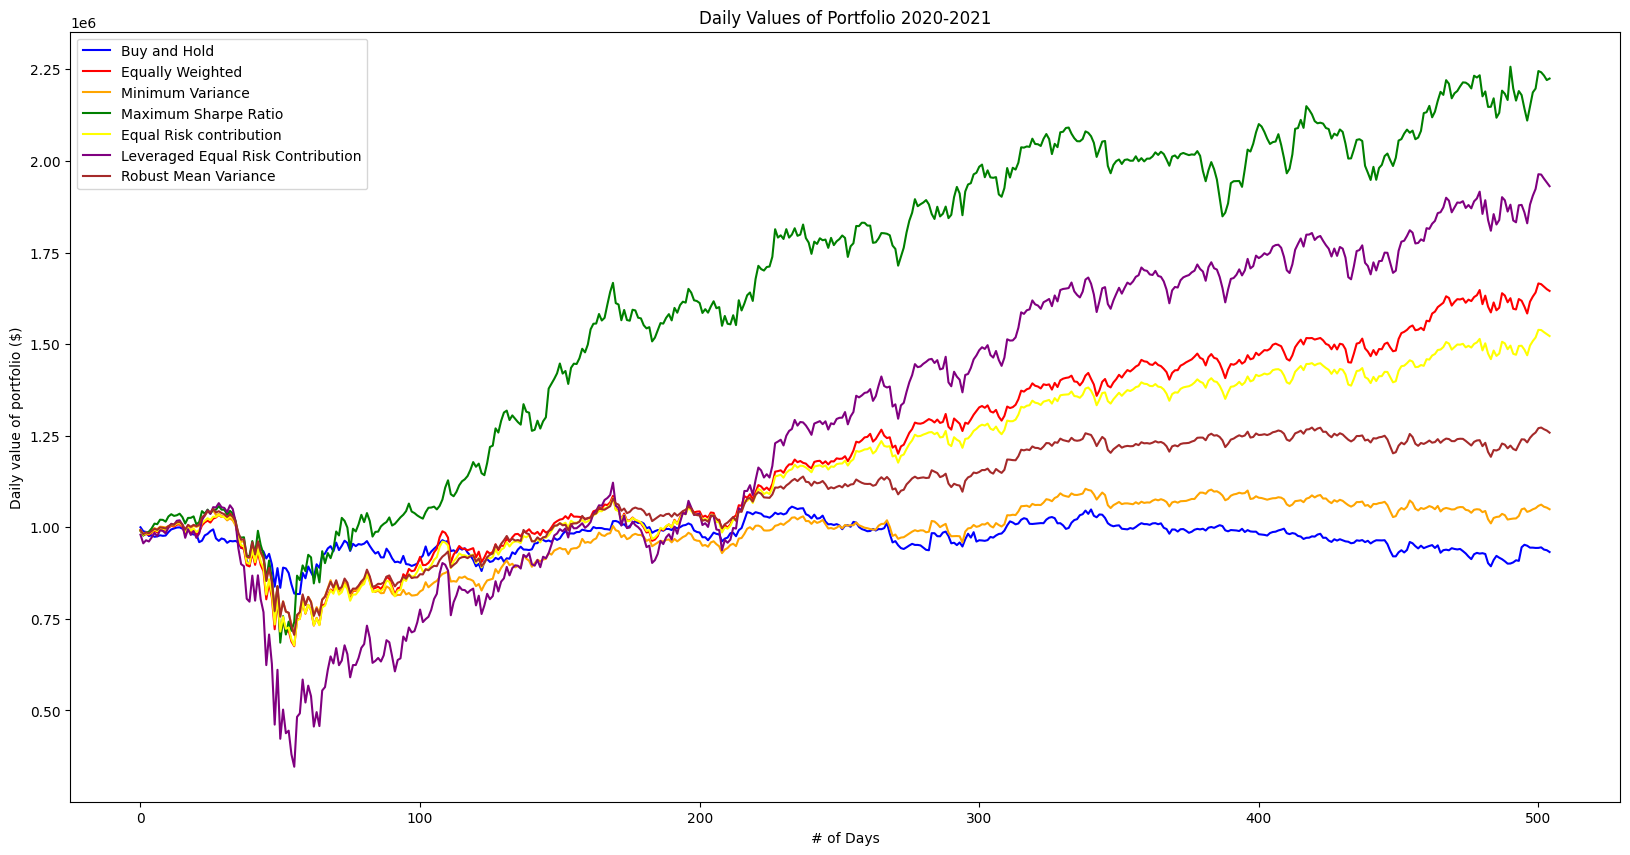

In [14]:
#Plot the daily value of the portfolio (for each trading strategy) over the years 2008 and 2009
plt.figure(figsize=(20,10))
plt.plot(portf_value[0], label='Buy and Hold', color='blue')
plt.plot(portf_value[1], label='Equally Weighted', color='red')
plt.plot(portf_value[2], label='Minimum Variance', color='orange')
plt.plot(portf_value[3], label='Maximum Sharpe Ratio', color='green')
plt.plot(portf_value[4],label='Equal Risk contribution', color = 'yellow')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contribution', color = 'purple')
plt.plot(portf_value[6],label='Robust Mean Variance', color = 'brown')
plt.title('Daily Values of Portfolio 2020-2021')
plt.xlabel('# of Days')
plt.ylabel('Daily value of portfolio ($)')
plt.legend()
plt.savefig('Daily Values of Portfolio 2020-2021')


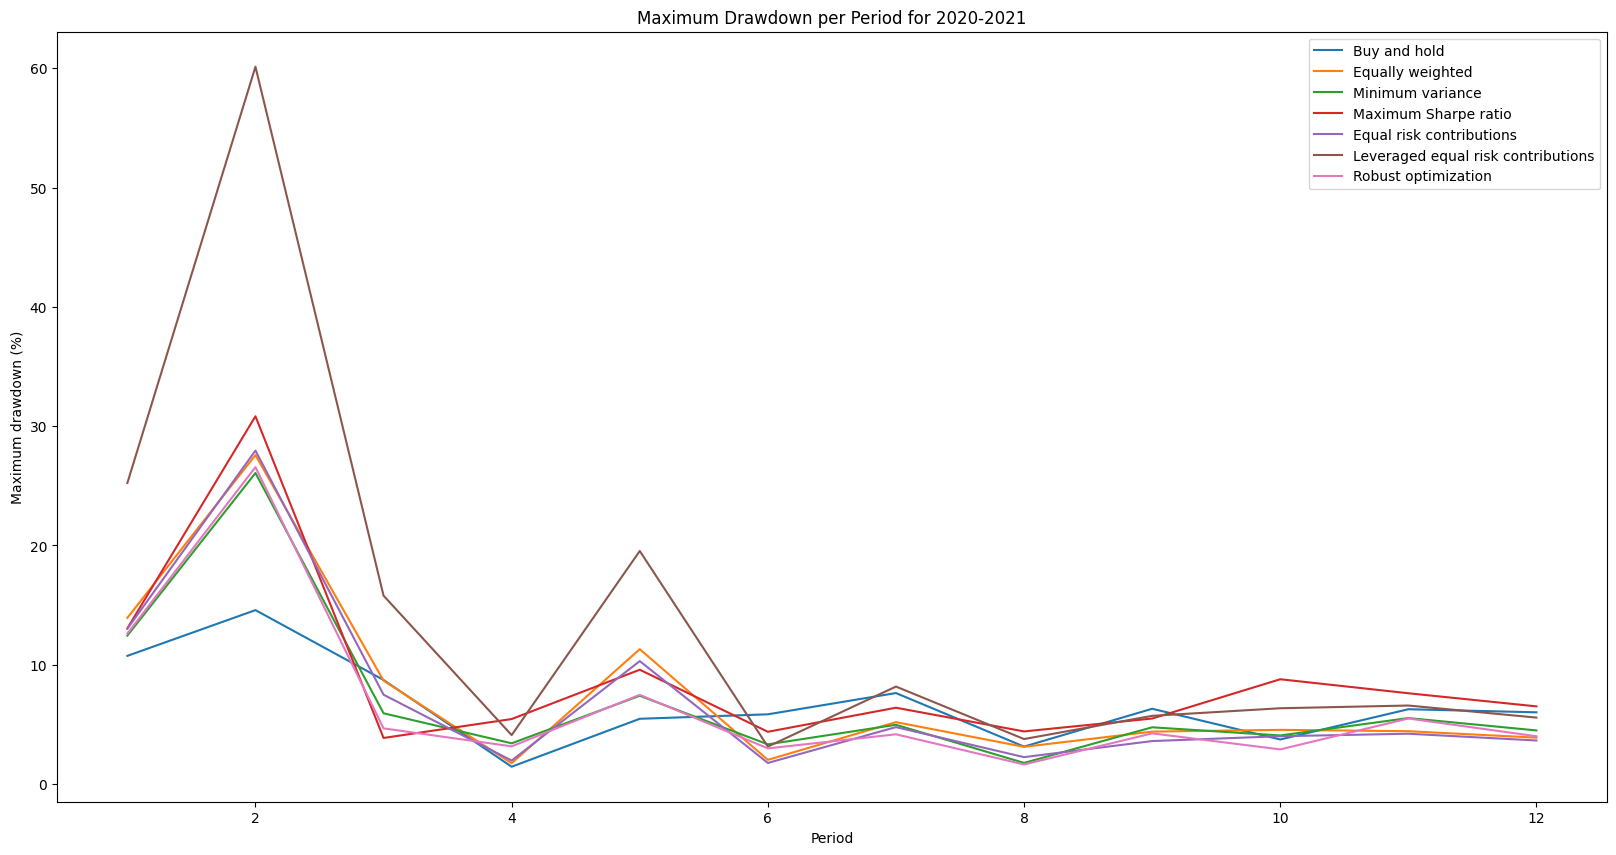

In [15]:
#Plot one chart in Python that illustrates maximum drawdown of your portfolio for each of the 12 periods
dfValues = pd.DataFrame()
for i in range(7):
    dfValues[str(i+1)] = portf_value[i].flatten()

dfList = []
indexArray = [[0,40],[41,82],[83,124],[125,167],[168,211],[212,252],[253,291],[292,334],[335,376],[377,419],[420,462],[463,504]]
for i in range(12):
    dfList.append(dfValues.loc[indexArray[i][0]:indexArray[i][1]])

maxDD_array = []
for i in range(12):
    periodArray = []
    for j in range(7):
        dfBuffer = ((dfList[i][str(j+1)] - dfList[i][str(j+1)].expanding().max()) / dfList[i][str(j+1)].expanding().max())*100
        dfBuffer = dfBuffer.abs()
        bufferVal = dfBuffer.max()
        periodArray.append(bufferVal)
    maxDD_array.append(periodArray)
    
dfMaxDD = pd.DataFrame()
for i in range(12):
    dfMaxDD[i+1] = maxDD_array[i] 
dfMaxDD = dfMaxDD.transpose()
dfMaxDD = dfMaxDD.rename(columns={0: "Buy and hold", 1: "Equally weighted", 2: "Minimum variance", 3: "Maximum Sharpe ratio", 4: "Equal risk contributions", 5: "Leveraged equal risk contributions", 6: "Robust optimization"})

dfMaxDD.plot(figsize=(20,10))
plt.title('Maximum Drawdown per Period for 2020-2021')
plt.xlabel('Period')
plt.ylabel('Maximum drawdown (%)')
plt.savefig('Maximum Drawdown per Period for 2020-2021')

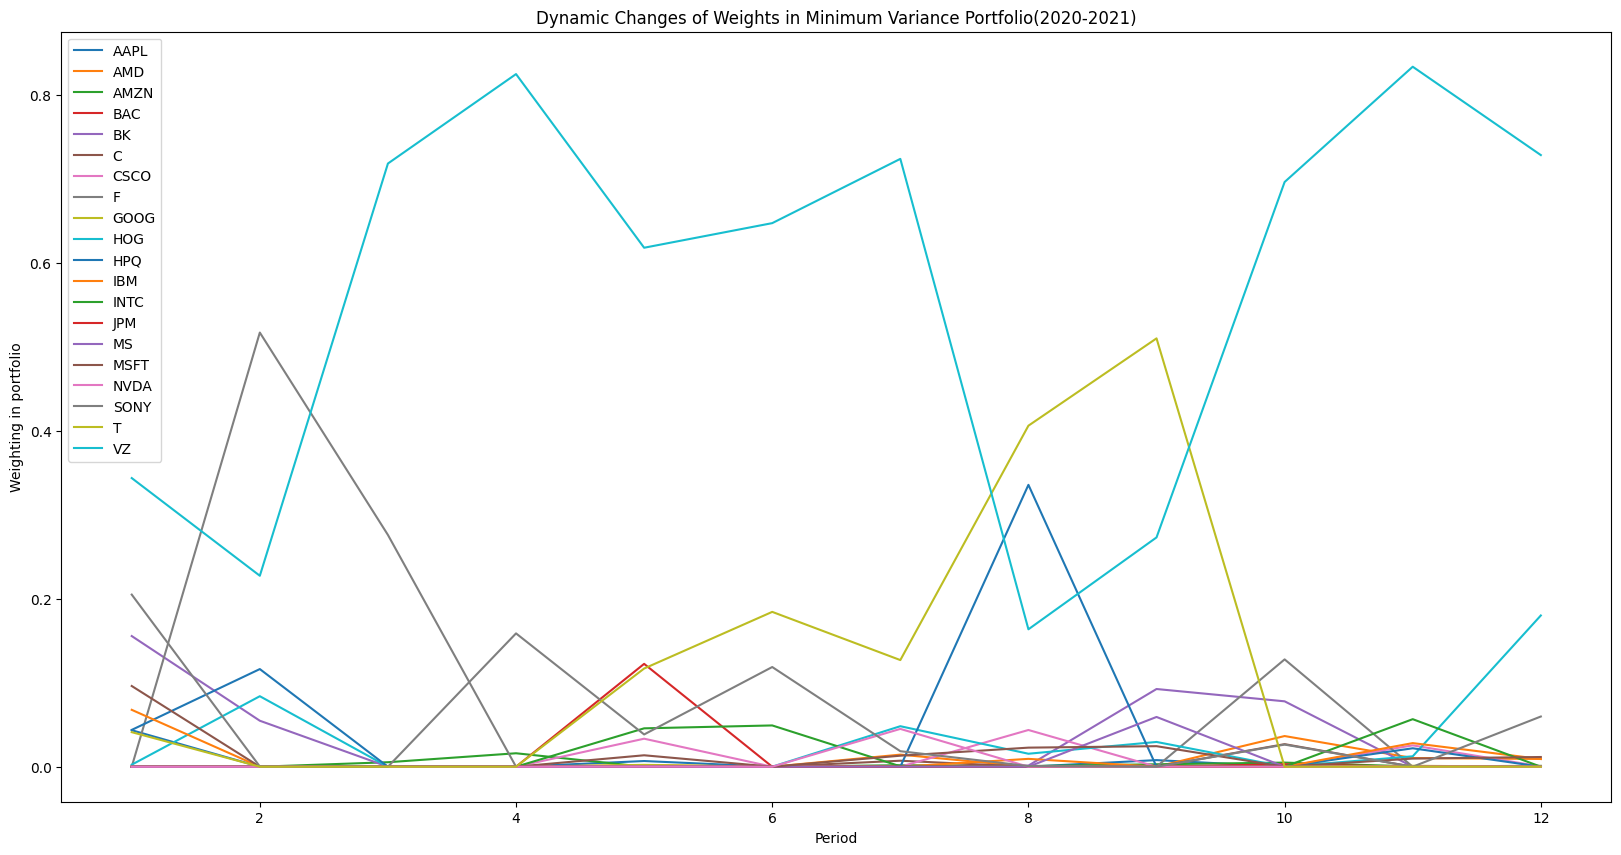

In [16]:
# Plot dynamic changes in portfolio allocations for strategy 3 Minimize Variance 
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[2, period-1]/sum(x[2, period-1]))
df_minVar = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_minVar.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Minimum Variance Portfolio(2020-2021)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.savefig('Dynamic Changes of Weights in Minimum Variance Portfolio(2020-2021)')

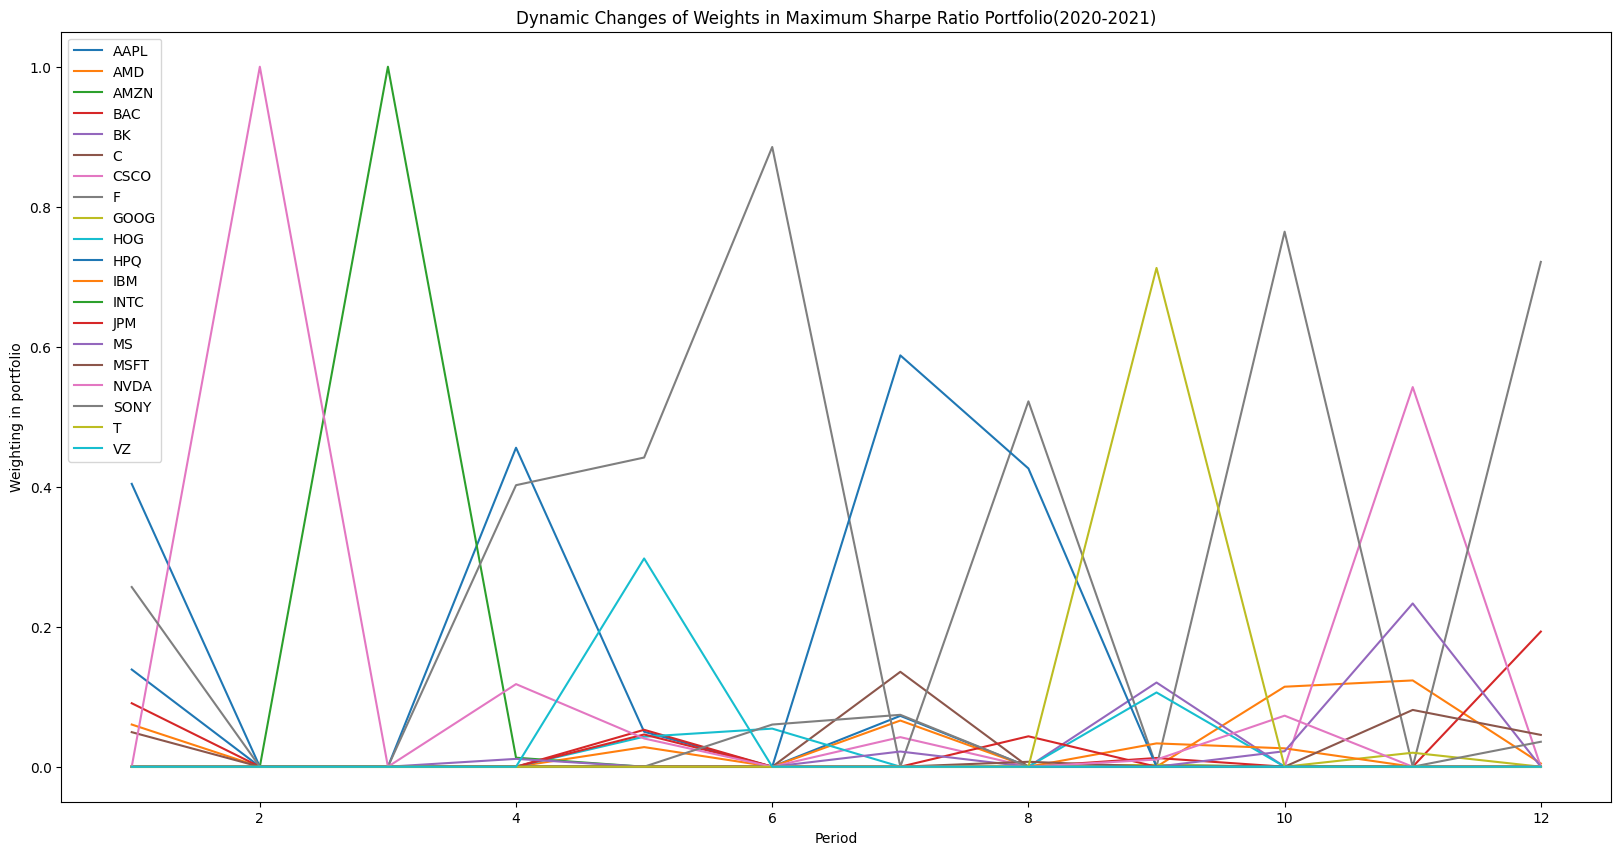

In [17]:
#Plot dynamic Changes in portfolio allocations for strategy 4 Maximize Sharpe Ratio 
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[3, period-1]/sum(x[3, period-1]))
df_maxSR = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_maxSR.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Maximum Sharpe Ratio Portfolio(2020-2021)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.savefig('Dynamic Changes of Weights in Maximum Sharpe Ratio Portfolio(2020-2021)')

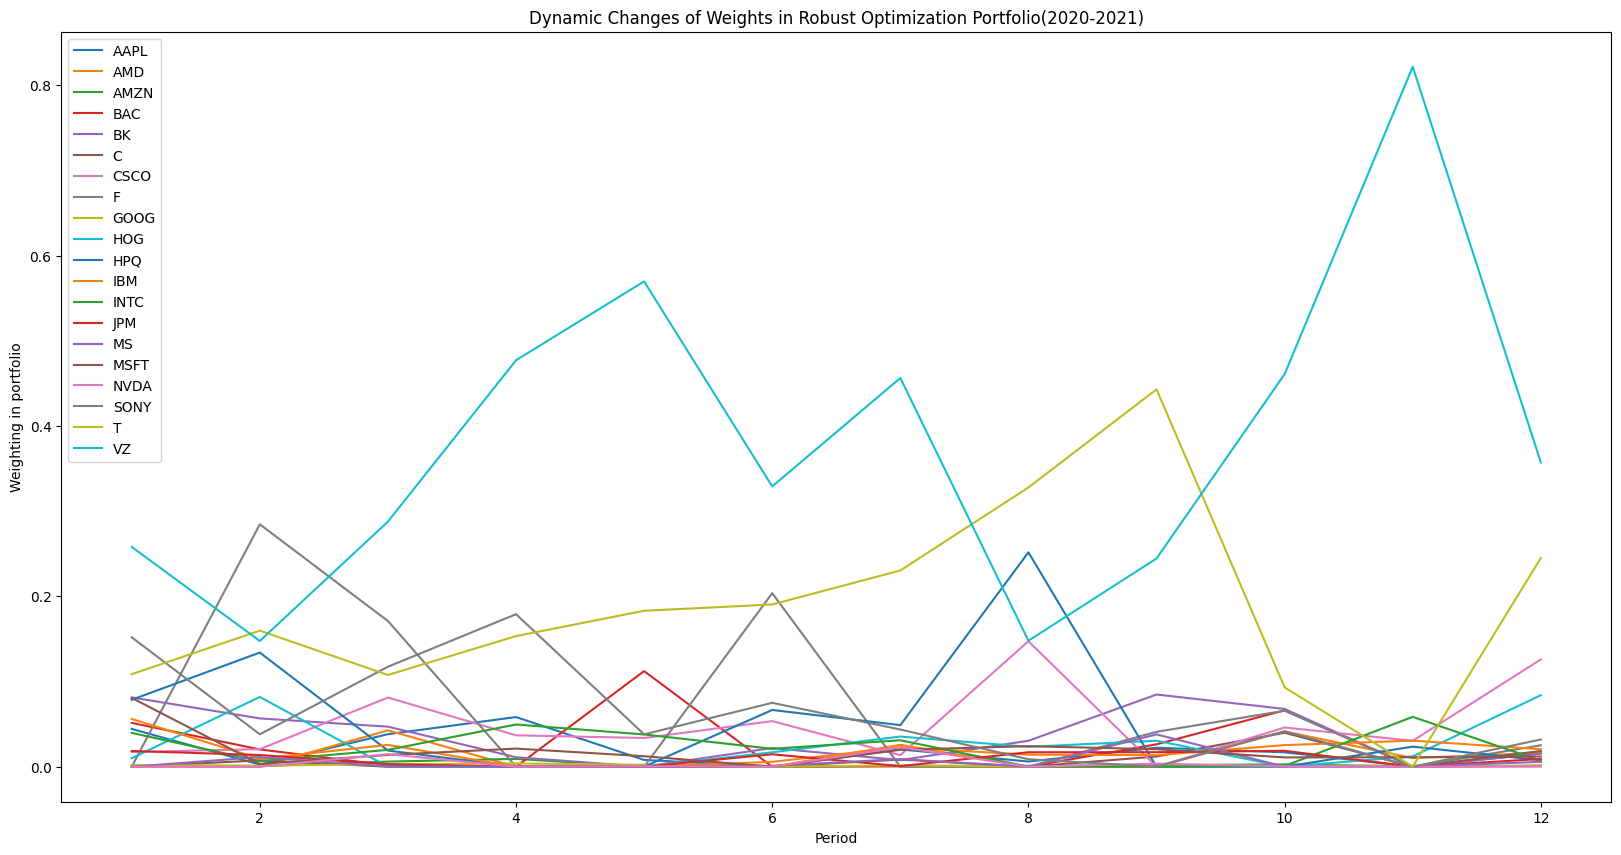

In [18]:
# Plot dynamic changes in portfolio allocations under strategy 7 Robust mean-variance optimization
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[6, period-1]/sum(x[6, period-1]))
df_minVar = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_minVar.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Robust Optimization Portfolio(2020-2021)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.savefig('Dynamic Changes of Weights in Robust Optimization Portfolio(2020-2021)')

In [19]:
 trading_cost.T

array([[0, 9123.561708755493, 7255.039977798462, 9928.704977798463,
        8707.916708755492, 12730.551708755493, 7851.119977798462],
       [0, 410.41532236820103, 6018.213070807813, 9628.241352116478,
        1396.5452396222029, 2776.78046903874, 3818.3977757841985],
       [0, 570.8700356959206, 3014.071903791783, 9756.984749854215,
        739.2138577215094, 1460.5370415503132, 3081.7345223536436],
       [0, 366.2264084699701, 2481.390482254191, 7305.440815477881,
        890.7131125235895, 1762.0034113030392, 1573.8866178793799],
       [0, 620.8621090988509, 5343.377956458604, 11375.145108635254,
        2431.0932011963578, 4796.494291071186, 4929.247852744535],
       [0, 387.0737234173764, 1995.5687660978356, 13718.461332419556,
        1345.9850504576004, 2652.6253957970057, 3354.2020962775687],
       [0, 472.4153440565987, 2827.4428679996295, 14702.41397784049,
        2481.763755095433, 4861.822991289685, 3737.933329737623],
       [0, 612.3579635306462, 5911.452828825755

In [20]:
df_tc = pd.DataFrame(trading_cost.T, columns=strategy_names, index=[1,2,3,4,5,6,7,8,9,10,11,12])

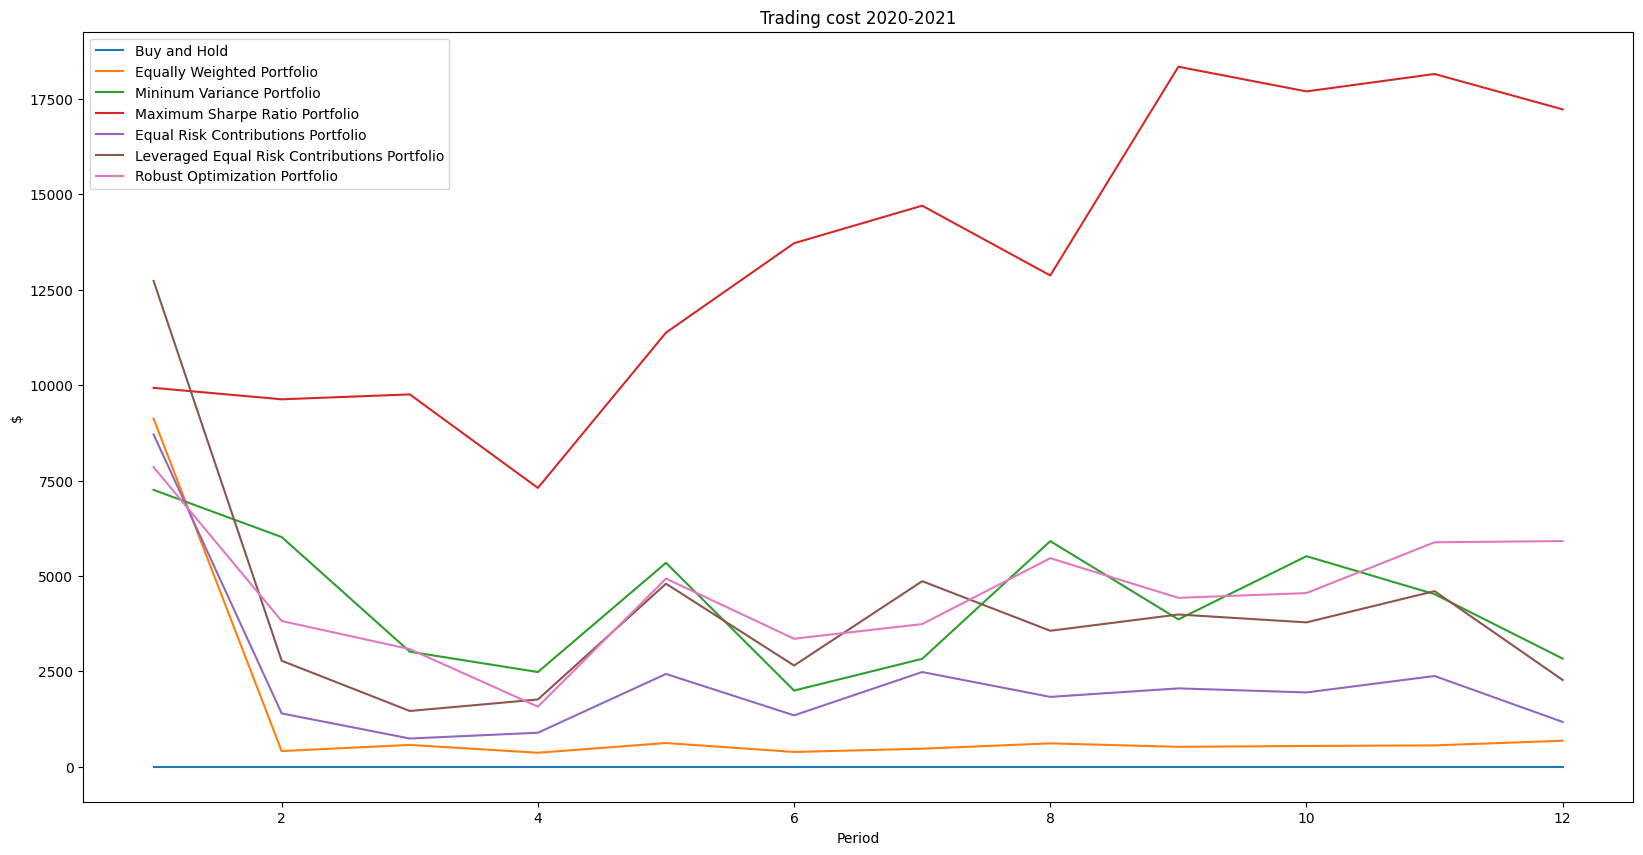

In [21]:
df_tc.plot(figsize=(20,10))
plt.title('Trading cost 2020-2021')
plt.xlabel('Period')
plt.ylabel('$')
plt.savefig('Trading cost 2020-2021')

In [22]:
df_result = pd.DataFrame(np.round(portf_value[0], 2), columns = ['Buy and Hold'])
df_result['Equally Weighted Portfolio'] = np.round(portf_value[1], 2)
df_result['Minimum Variance Portfolio'] = np.round(portf_value[2], 2)
df_result['Maximum Sharpe Ratio Portfolio'] = np.round(portf_value[3], 2)
df_result['Equal Risk Contributions'] = np.round(portf_value[4], 2)
df_result['Leveraged Equal Risk Contributions'] = np.round(portf_value[5], 2)
df_result['Robust Optimization'] = np.round(portf_value[6], 2)

In [23]:
df_result['Buy and Hold daily returns'] = df_result['Buy and Hold'].pct_change()
df_result['Equally Weighted Portfolio daily returns'] = df_result['Equally Weighted Portfolio'].pct_change()
df_result['Minimum Variance Portfolio daily returns'] = df_result['Minimum Variance Portfolio'].pct_change()
df_result['Maximum Sharpe Ratio Portfolio daily returns'] = df_result['Maximum Sharpe Ratio Portfolio'].pct_change()
df_result['Equal Risk Contributions daily returns'] = df_result['Equal Risk Contributions'].pct_change()
df_result['Leveraged Equal Risk Contributions daily returns'] = df_result['Leveraged Equal Risk Contributions'].pct_change()
df_result['Robust Optimization daily returns'] = df_result['Robust Optimization'].pct_change()

In [24]:
df_result['Buy and Hold cumulative_returns'] = (1 + df_result['Buy and Hold daily returns']).cumprod() - 1
df_result['Equally Weighted cumulative_returns'] = (1 + df_result['Equally Weighted Portfolio daily returns']).cumprod() - 1
df_result['Minimum Variance cumulative_returns'] = (1 + df_result['Minimum Variance Portfolio daily returns']).cumprod() - 1
df_result['Maximum Sharpe Ratio cumulative_returns'] = (1 + df_result['Maximum Sharpe Ratio Portfolio daily returns']).cumprod() - 1
df_result['Equal Risk Contributions cumulative_returns'] = (1 + df_result['Equal Risk Contributions daily returns']).cumprod() - 1
df_result['Leveraged Equal Risk Contributions cumulative_returns'] = (1 + df_result['Leveraged Equal Risk Contributions daily returns']).cumprod() - 1
df_result['Robust Optimization cumulative_returns'] = (1 + df_result['Robust Optimization daily returns']).cumprod() - 1


In [25]:
df_result

,Buy and Hold,Equally Weighted Portfolio,Minimum Variance Portfolio,Maximum Sharpe Ratio Portfolio,Equal Risk Contributions,Leveraged Equal Risk Contributions,Robust Optimization,Buy and Hold daily returns,Equally Weighted Portfolio daily returns,Minimum Variance Portfolio daily returns,...,Equal Risk Contributions daily returns,Leveraged Equal Risk Contributions daily returns,Robust Optimization daily returns,Buy and Hold cumulative_returns,Equally Weighted cumulative_returns,Minimum Variance cumulative_returns,Maximum Sharpe Ratio cumulative_returns,Equal Risk Contributions cumulative_returns,Leveraged Equal Risk Contributions cumulative_returns,Robust Optimization cumulative_returns
0,1000013.00,990889.43,992757.96,990084.29,991305.08,979782.35,992161.88,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,989002.66,978044.98,981497.53,977369.85,979494.53,956189.63,981342.87,-0.011010,-0.012963,-0.011343,...,-0.011914,-0.024080,-0.010904,-0.011010,-0.012963,-0.011343,-0.012842,-0.011914,-0.024080,-0.010904
2,987178.54,981436.27,985852.02,984877.69,983687.44,964565.38,985799.59,-0.001844,0.003467,0.004437,...,0.004281,0.008760,0.004541,-0.012834,-0.009540,-0.006956,-0.005259,-0.007684,-0.015531,-0.006413
3,976096.27,979330.79,985157.50,987892.27,981986.74,961168.10,983560.12,-0.011226,-0.002145,-0.000704,...,-0.001729,-0.003522,-0.002272,-0.023916,-0.011665,-0.007656,-0.002214,-0.009400,-0.018998,-0.008670
4,978285.74,984692.63,991627.29,997010.17,987572.39,972325.91,989971.82,0.002243,0.005475,0.006567,...,0.005688,0.011609,0.006519,-0.021727,-0.006254,-0.001139,0.006995,-0.003765,-0.007610,-0.002207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,943757.79,1665620.70,1058443.84,2245420.12,1538892.60,1963725.58,1270495.20,0.000153,0.015083,0.006038,...,0.013696,0.020863,0.009364,-0.056254,0.680935,0.066165,1.267908,0.552391,1.004247,0.280532
501,945207.14,1663588.10,1061846.89,2242006.57,1538423.34,1962819.83,1272273.21,0.001536,-0.001220,0.003215,...,-0.000305,-0.000461,0.001399,-0.054805,0.678884,0.069593,1.264460,0.551917,1.003322,0.282324
502,939108.44,1656818.36,1056062.62,2233120.83,1532584.03,1951548.67,1267557.87,-0.006452,-0.004069,-0.005447,...,-0.003796,-0.005742,-0.003706,-0.060904,0.672052,0.063766,1.255486,0.546027,0.991819,0.277572
503,937449.87,1650054.88,1053654.26,2220743.89,1527167.12,1941092.83,1264100.06,-0.001766,-0.004082,-0.002281,...,-0.003534,-0.005358,-0.002728,-0.062562,0.665226,0.061341,1.242985,0.540562,0.981147,0.274087


In [26]:
df_result_daily_ret = df_result[['Buy and Hold daily returns', 
                                 'Equally Weighted Portfolio daily returns', 
                                 'Minimum Variance Portfolio daily returns', 
                                 'Maximum Sharpe Ratio Portfolio daily returns', 
                                 'Equal Risk Contributions daily returns', 
                                 'Leveraged Equal Risk Contributions daily returns', 
                                 'Robust Optimization daily returns']]

In [27]:
df_result_daily_ret

,Buy and Hold daily returns,Equally Weighted Portfolio daily returns,Minimum Variance Portfolio daily returns,Maximum Sharpe Ratio Portfolio daily returns,Equal Risk Contributions daily returns,Leveraged Equal Risk Contributions daily returns,Robust Optimization daily returns
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.011010,-0.012963,-0.011343,-0.012842,-0.011914,-0.024080,-0.010904
2,-0.001844,0.003467,0.004437,0.007682,0.004281,0.008760,0.004541
3,-0.011226,-0.002145,-0.000704,0.003061,-0.001729,-0.003522,-0.002272
4,0.002243,0.005475,0.006567,0.009230,0.005688,0.011609,0.006519
...,...,...,...,...,...,...,...
500,0.000153,0.015083,0.006038,0.021749,0.013696,0.020863,0.009364
501,0.001536,-0.001220,0.003215,-0.001520,-0.000305,-0.000461,0.001399
502,-0.006452,-0.004069,-0.005447,-0.003963,-0.003796,-0.005742,-0.003706
503,-0.001766,-0.004082,-0.002281,-0.005542,-0.003534,-0.005358,-0.002728


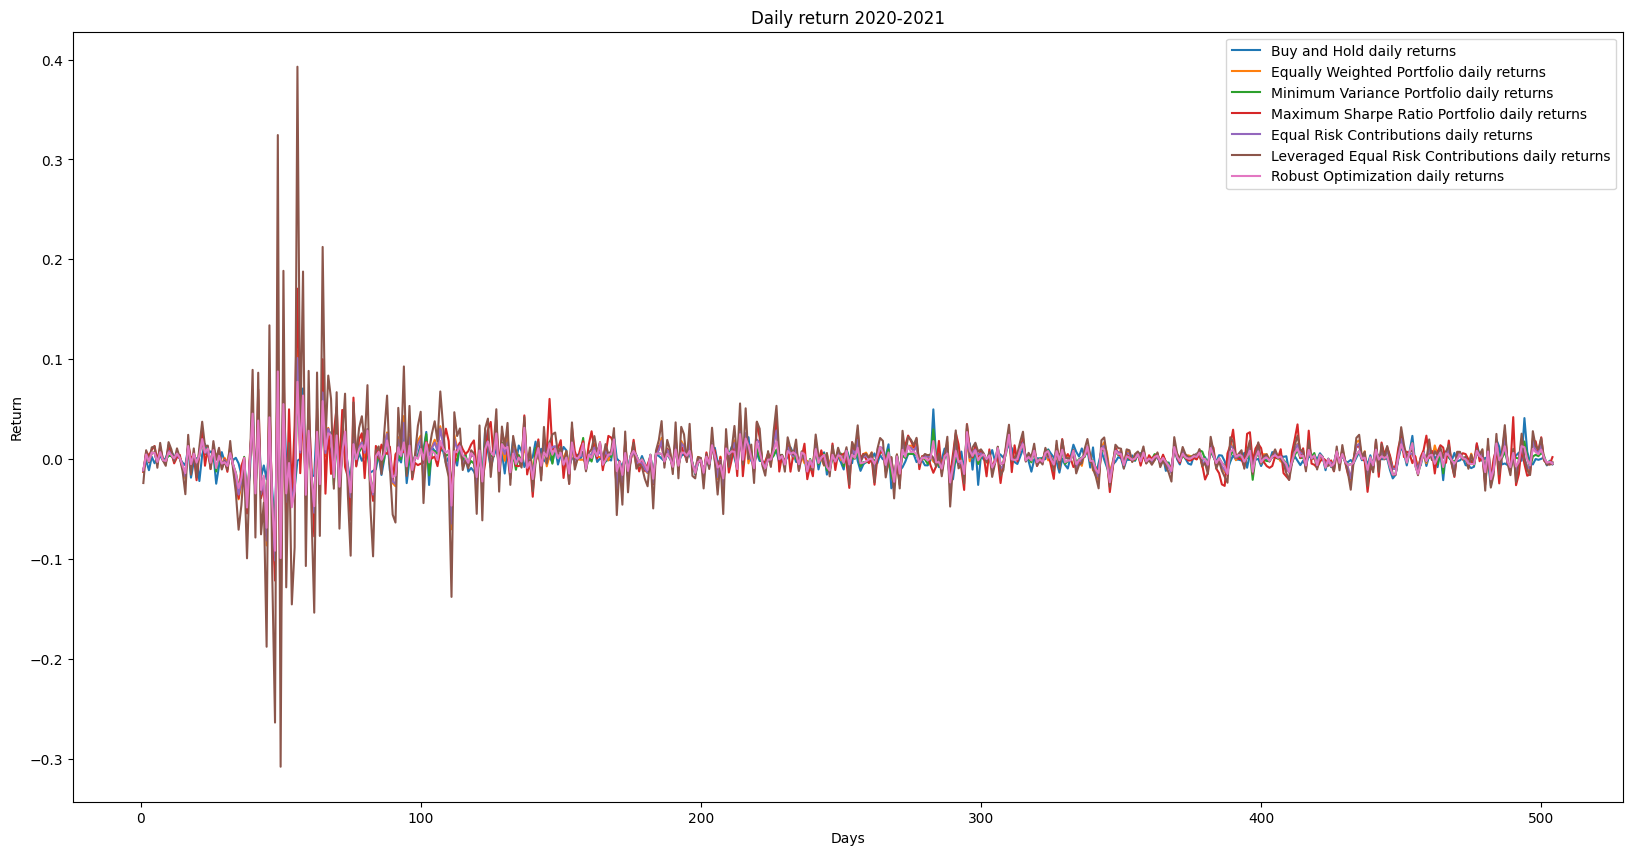

In [28]:
df_result_daily_ret.plot(figsize=(20,10))
plt.title('Daily return 2020-2021')
plt.xlabel('Days')
plt.ylabel('Return')
plt.savefig('Daily return 2020-2021')

In [29]:
df_result_cum_ret = df_result[['Buy and Hold cumulative_returns', 
                                 'Equally Weighted cumulative_returns', 
                                 'Minimum Variance cumulative_returns', 
                                 'Maximum Sharpe Ratio cumulative_returns', 
                                 'Equal Risk Contributions cumulative_returns', 
                                 'Leveraged Equal Risk Contributions cumulative_returns', 
                                 'Robust Optimization cumulative_returns']]

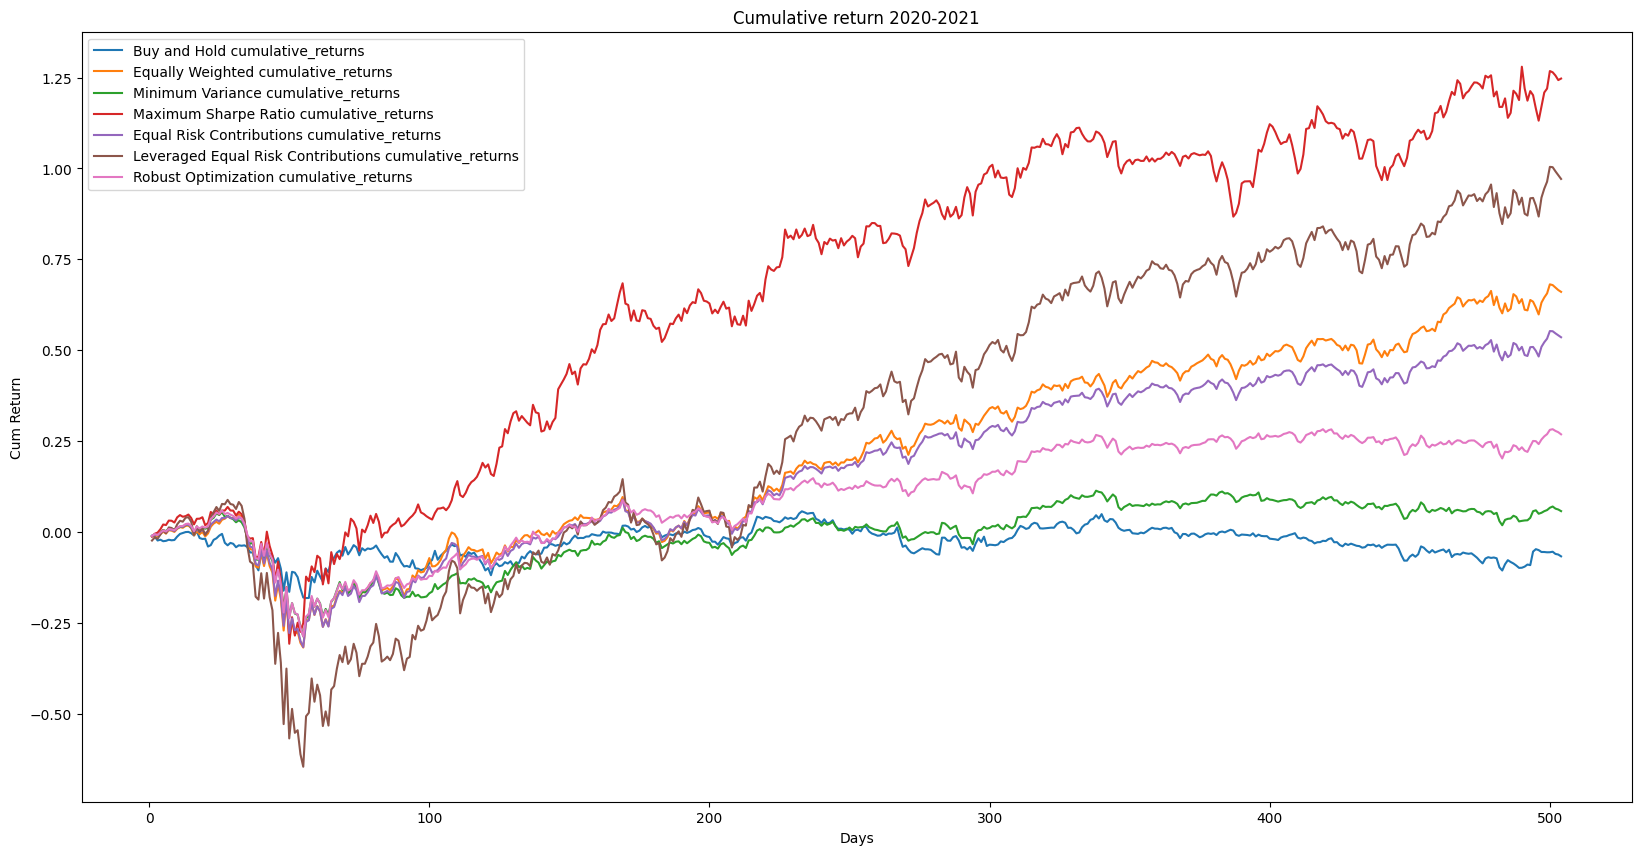

In [30]:
df_result_cum_ret.plot(figsize=(20,10))
plt.title('Cumulative return 2020-2021')
plt.xlabel('Days')
plt.ylabel('Cum Return')
plt.savefig('Cumulative return 2020-2021')

In [31]:
daily_r_rf = (r_rf+1)**(1.0/252)-1
sharpe_ratio_buynhold = (df_result['Buy and Hold daily returns'].mean() - daily_r_rf)/df_result['Buy and Hold daily returns'].std()
sharpe_ratio_ew = (df_result['Equally Weighted Portfolio daily returns'].mean() - daily_r_rf)/df_result['Equally Weighted Portfolio daily returns'].std()
sharpe_ratio_minvar = (df_result['Minimum Variance Portfolio daily returns'].mean() - daily_r_rf)/df_result['Minimum Variance Portfolio daily returns'].std()
sharpe_ratio_maxsharpe = (df_result['Maximum Sharpe Ratio Portfolio daily returns'].mean() - daily_r_rf)/df_result['Maximum Sharpe Ratio Portfolio daily returns'].std()
sharpe_ratio_erc = (df_result['Equal Risk Contributions daily returns'].mean() - daily_r_rf)/df_result['Equal Risk Contributions daily returns'].std()
sharpe_ratio_lerc = (df_result['Leveraged Equal Risk Contributions daily returns'].mean() - daily_r_rf)/df_result['Leveraged Equal Risk Contributions daily returns'].std()
sharpe_ratio_ro = (df_result['Robust Optimization daily returns'].mean() - daily_r_rf)/df_result['Robust Optimization daily returns'].std()

In [32]:
sharpe_ratio_buynhold = sharpe_ratio_buynhold * (252**0.5)
sharpe_ratio_ew = sharpe_ratio_ew * (252**0.5)
sharpe_ratio_minvar = sharpe_ratio_minvar * (252**0.5)
sharpe_ratio_maxsharpe = sharpe_ratio_maxsharpe * (252**0.5)
sharpe_ratio_erc = sharpe_ratio_erc * (252**0.5)
sharpe_ratio_lerc = sharpe_ratio_lerc * (252**0.5)
sharpe_ratio_ro  = sharpe_ratio_ro  * (252**0.5)

In [33]:
sharpe_ratio_buynhold

-0.1980762317438821

In [34]:
sharpe_ratio_ew

0.9342998875699868

In [35]:
sharpe_ratio_minvar

0.12496088520850301

In [36]:
sharpe_ratio_maxsharpe

1.2127872345405382

In [37]:
sharpe_ratio_erc

0.8328469589621469

In [38]:
sharpe_ratio_lerc

0.7954793888384374

In [39]:
sharpe_ratio_ro

0.5152688347736064